In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

import warnings
warnings.filterwarnings("ignore")


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
import imageio
import glob
import os
import cv2


In [3]:


path_to_data = "/content/drive/My Drive/mia/data"

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


t1_files = glob.glob(f'{path_to_data}/TrainT1/*.png')
t2_files = glob.glob(f'{path_to_data}/TrainT2/*.png')




In [4]:
imgT1 = [np.array(Image.open(t1)) for t1 in t1_files]
imgT2 = [np.array(Image.open(t2)) for t2 in t2_files]

In [5]:
print("Shape of type1 MRI",imgT1[0].shape)
print("Shape of type2 MRI",imgT2[0].shape)

Shape of type1 MRI (217, 181)
Shape of type2 MRI (217, 181)


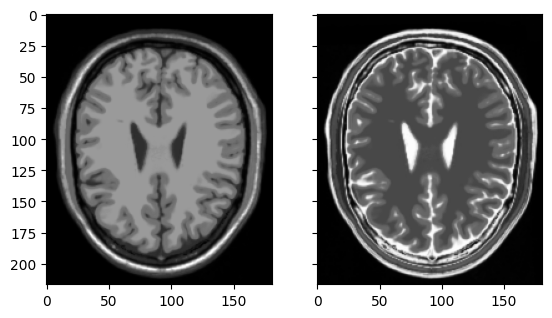

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(imgT1[0], cmap='gray')
ax2.imshow(imgT2[0], cmap='gray')

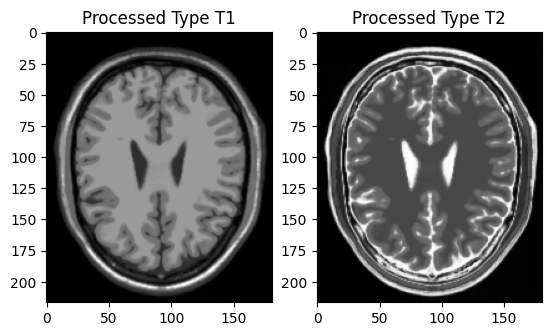

In [5]:

EPOCHS = 300
BATCH_SIZE = 5
len_dataset = max(len(t1_files), len(t2_files)) // BATCH_SIZE

imgT1 = np.stack(imgT1, axis=0)
imgT1 = imgT1 / 127.5 - 1
imgT2 = np.stack(imgT2, axis=0)
imgT2 = imgT2 / 127.5 - 1


f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imgT1[0], cmap='gray')
ax2.imshow(imgT2[0], cmap='gray')
ax1.title.set_text('Processed Type T1')
ax2.title.set_text('Processed Type T2')
plt.show()

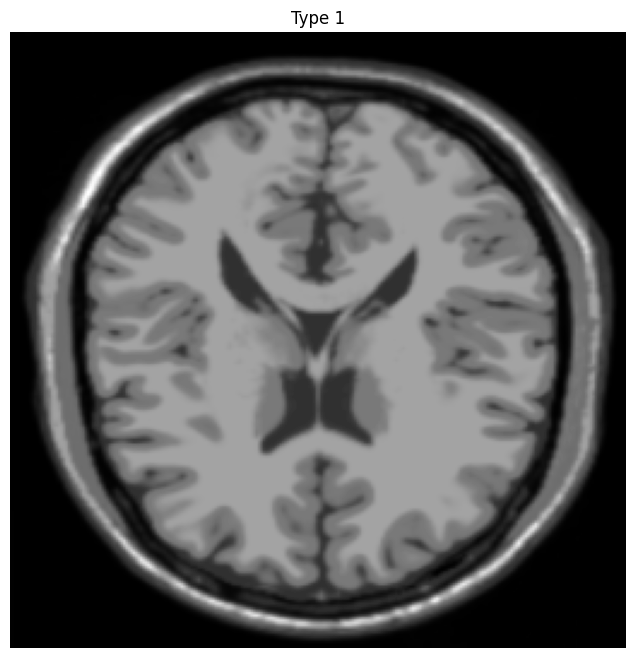

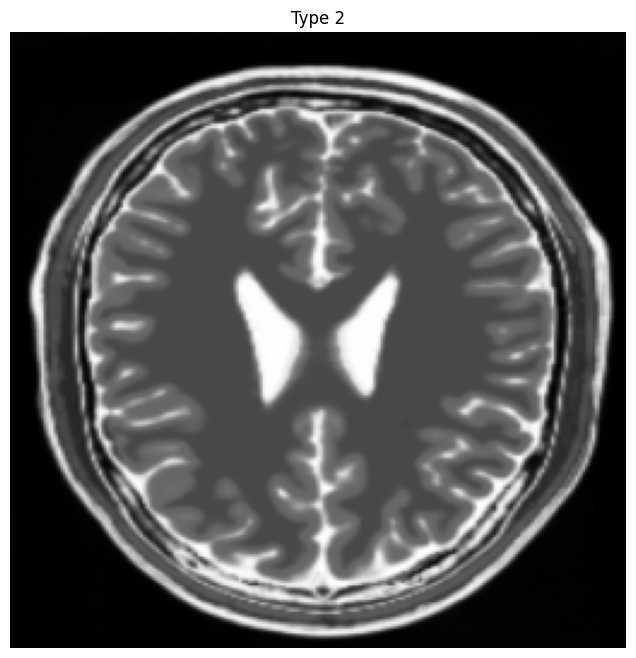

In [6]:

typet1_data = np.zeros((imgT1.shape[0], 256, 256, 1))
for index, img in enumerate(imgT1):
    typet1_data[index, :, :, :] = resize(img, (256, 256, 1))

typet2_data = np.zeros((imgT2.shape[0], 256, 256, 1))
for index, img in enumerate(imgT2):
    typet2_data[index, :, :, :] = resize(img, (256, 256, 1))

typet1_data = typet1_data.reshape(typet1_data.shape[0], 256, 256, 1).astype('float32')
typet2_data = typet2_data.reshape(typet2_data.shape[0], 256, 256, 1).astype('float32')

typet1_data = tf.data.Dataset.from_tensor_slices(typet1_data).shuffle(imgT1.shape[0], seed=100).batch(BATCH_SIZE)
typet2_data = tf.data.Dataset.from_tensor_slices(typet2_data).shuffle(imgT2.shape[0], seed=100).batch(BATCH_SIZE)


sample_typet1 = next(iter(typet1_data))
plt.figure(figsize=(8, 8))
plt.imshow(sample_typet1[0].numpy()[:, :, 0], cmap='gray')
plt.title('Type 1')
plt.axis('off')
plt.show()

sample_typet2 = next(iter(typet2_data))
plt.figure(figsize=(8, 8))
plt.imshow(sample_typet2[0].numpy()[:, :, 0], cmap='gray')
plt.title('Type 2')
plt.axis('off')
plt.show()

In [7]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [8]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    down_layers = tf.keras.Sequential()
    #adding Conv2D layer
    down_layers.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                                        kernel_initializer = initializer, use_bias = False))
    #adding normalization
    if apply_norm:
        down_layers.add(InstanceNormalization())
    #adding activation function as Leaky Relu
    down_layers.add(tf.keras.layers.LeakyReLU())
    return down_layers


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    up_layers = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    up_layers.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    up_layers.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        up_layers.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    up_layers.add(tf.keras.layers.ReLU())
    return up_layers


def unet_generator():
    down_stack = [
        downsample(64, 4, False), #(bs, 128, 128, 64)
        downsample(128, 4), #(bs, 64, 64, 128)
        downsample(256, 4), #(bs, 32, 32, 256)
        downsample(512, 4), #(bs, 16, 16, 512)
        downsample(512, 4), #(bs, 8, 8, 512)
        downsample(512, 4), #(bs, 4, 4, 512)
        downsample(512, 4), #(bs, 2, 2, 512)
        downsample(512, 4) #(bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 1)
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])
    concat = tf.keras.layers.Concatenate()
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)




In [9]:
generator_g = unet_generator()
generator_f = unet_generator()

In [12]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         1024      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131328    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          524800    ['sequential_1[0][0]']        
                                                                                              

In [10]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')

    down1 = downsample(64, 4, False)(inp) #(bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) #(bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) #(bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    instancenorm = InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(instancenorm)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [11]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [15]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 sequential_30 (Sequential)  (None, 128, 128, 64)      1024      
                                                                 
 sequential_31 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_32 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d (ZeroPaddin  (None, 34, 34, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           

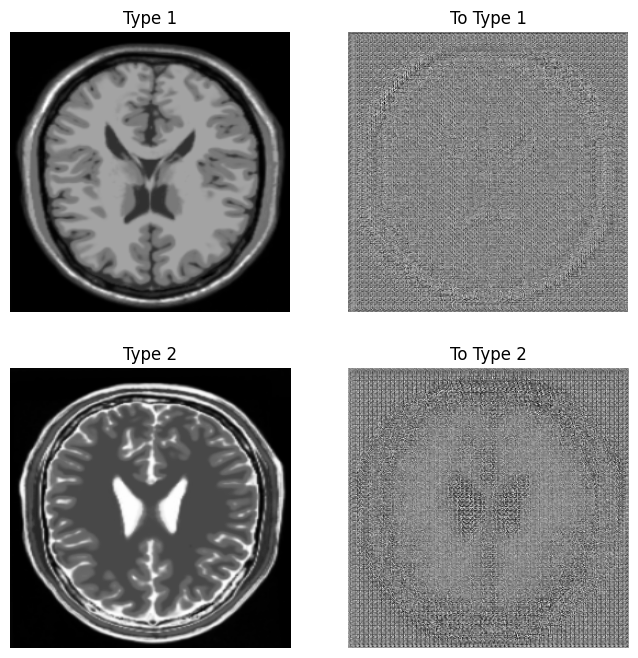

In [16]:
to_type1 = generator_g(sample_typet1)
to_type2 = generator_f(sample_typet2)
plt.figure(figsize=(8, 8))

imgs = [sample_typet1, to_type1, sample_typet2, to_type2]
title = ['Type 1', 'To Type 1', 'Type 2', 'To Type 2']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

In [12]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

In [14]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [15]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

In [16]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

In [17]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [18]:
checkpoint_path = "/content/drive/My Drive//mia/trainedmodel"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [19]:
def generate_images(model1, test_input1, model2, test_input2, output_dir, epoch):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(16, 8))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image T1', 'T1 to T2 Converted', 'Input Image T2', 'T2 to T1 Converted']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    plt.savefig('{}/image_at_epoch_{:03d}.png'.format(output_dir, epoch))
    plt.show()

In [20]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [21]:
for epoch in range(1, EPOCHS + 1):
    for image_x, image_y in tf.data.Dataset.zip((typet1_data, typet2_data)):
        train_step(image_x, image_y)


    generate_images(generator_g, sample_typet1, generator_f, sample_typet2, '/content/drive/My Drive/mia/outputimage', epoch)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)


Output hidden; open in https://colab.research.google.com to view.